In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from torch import nn
import torch
from PIL import Image
from torch.nn import functional as F
import torch.utils.model_zoo as model_zoo
from torchvision import models

In [3]:
# content=Image.open('./datasets/content.jpg')
content=Image.open('./datasets/Tuebingen_Neckarfront.jpg')
style=Image.open('./datasets/style.jpg')

In [4]:
content=content.resize(style.size)

In [5]:
def to_float_tensor(item): return item.float().div_(255.)
def to_byte_tensor(item):
    res = torch.ByteTensor(torch.ByteStorage.from_buffer(item.tobytes()))
    w,h = item.size
    return res.view(h,w,-1).permute(2,0,1)

In [6]:
content=content.resize(content.size)
style=to_float_tensor(to_byte_tensor(style))
content=to_float_tensor(to_byte_tensor(content))

In [7]:
import matplotlib.pyplot as plt
def show_image(im, figsize=(10,10)):
    plt.figure(figsize=figsize)
    plt.axis('off')
    plt.imshow(im.permute(1,2,0))

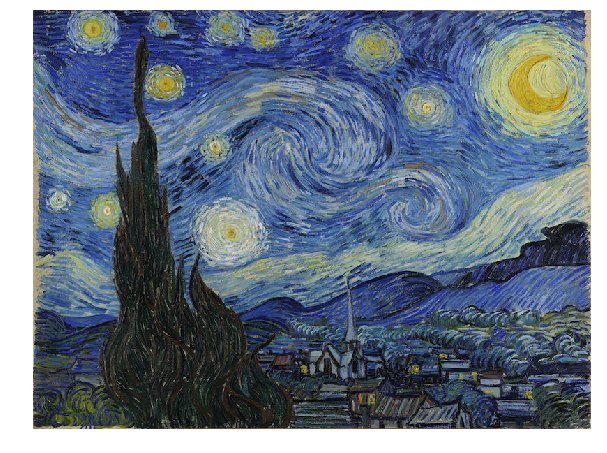

In [8]:
show_image(style)

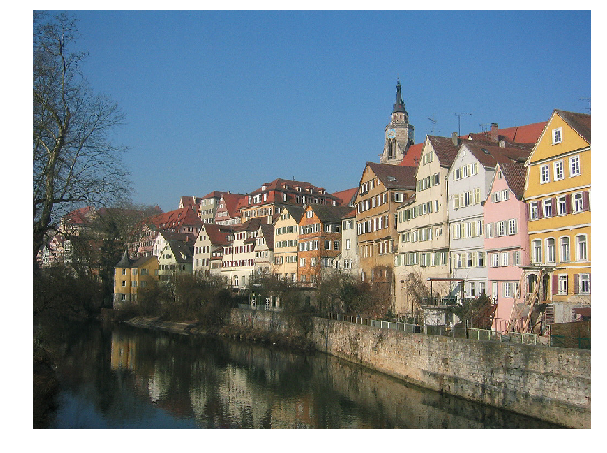

In [9]:
show_image(content)

In [10]:
def normalize_chan(x, mean, std):
    return (x-mean[...,None,None]) / std[...,None,None]

In [11]:
mean_c,std_c=content.mean([1,2]),content.std([1,2])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


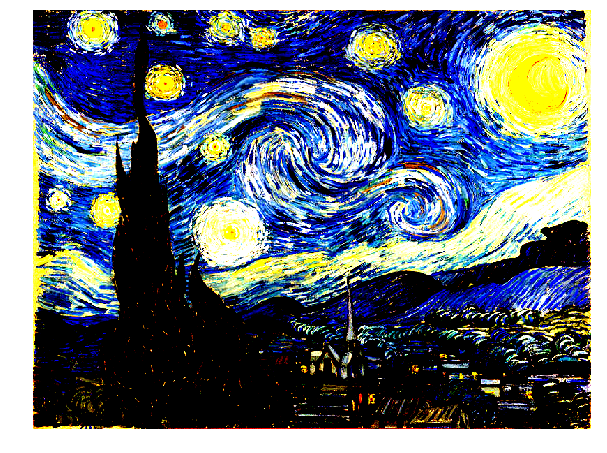

In [12]:
style=normalize_chan(style,style.mean([1,2]),style.std([1,2]))
content=normalize_chan(content,content.mean([1,2]),content.std([1,2]))
show_image(style)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


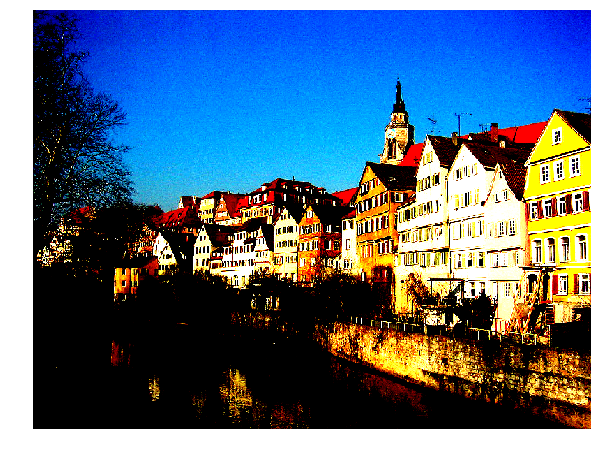

In [13]:
show_image(content)

In [14]:
style.shape,content.shape

(torch.Size([3, 600, 800]), torch.Size([3, 600, 800]))

In [15]:
# x=torch.nn.Parameter(torch.FloatTensor(content.shape))
x = torch.tensor(content, requires_grad=True, device='cuda')
# x = torch.tensor(torch.randn(content.shape), requires_grad=True, device='cuda')

/home/zhanglu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [16]:
def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

class VGG(nn.Module):

    def __init__(self, features,init_weights=True):
        super(VGG, self).__init__()
        self.features = features
        if init_weights:
            self._initialize_weights()

    def forward(self, x ,out_keys):
        out = {}
        out['r21'] = self.features[:10](x)
        out['r31'] = self.features[10:17](out['r21'])
        out['r41'] = self.features[17:27](out['r31'])
        out['r42'] = self.features[27:30](out['r41'])
        out['r51'] = self.features[30:37](out['r42'])
        out={k:out[k] for k in out_keys}
        return out

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
l=[64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']

In [17]:
pretrained_m=models.vgg16_bn(pretrained=True)
model = VGG(make_layers(l,batch_norm=True),init_weights=True)
model_dict = model.state_dict()

# 1. filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_m.state_dict().items() if k in model_dict}
# 2. overwrite entries in the existing state dict
model_dict.update(pretrained_dict) 
# 3. load the new state dict
model.load_state_dict(pretrained_dict)

<All keys matched successfully>

In [18]:
model=model.cuda()
out_keys=['r21','r31','r41','r42','r51',]

In [19]:
from fastai import *
from fastai.vision import *
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

base_loss = F.l1_loss
# base_loss= nn.MSELoss()
vgg_m = model.eval()

# print(vgg_m)
requires_grad(vgg_m, False)

In [20]:
# x=x.cuda()
content=content.cuda()
style=style.cuda()

In [21]:
style_target=vgg_m(style[None],['r21', 'r31', 'r41','r42','r51'])
content_target=vgg_m(content[None],['r42'])

In [22]:
opt=torch.optim.Adam([x],lr=0.1)

tensor(4.0561, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.0336, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.3985, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.0864, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.9185, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.8104, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7641, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6646, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6069, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5727, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5291, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4754, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4126, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3616, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3138, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2726, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2664, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2603, device='cuda:0', grad_fn=<AddBack

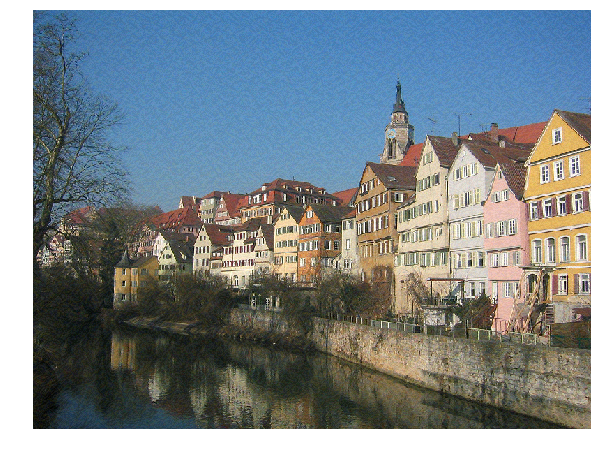

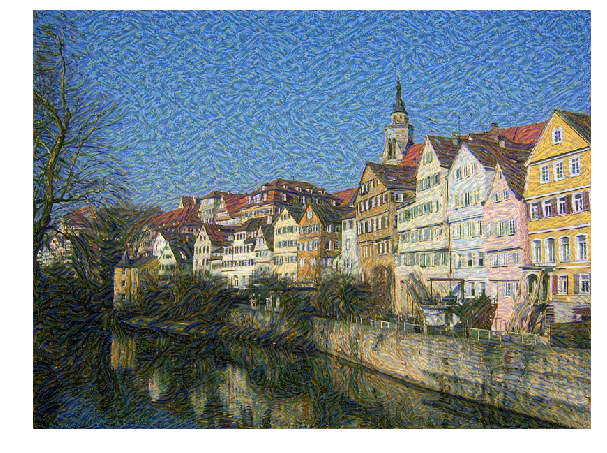

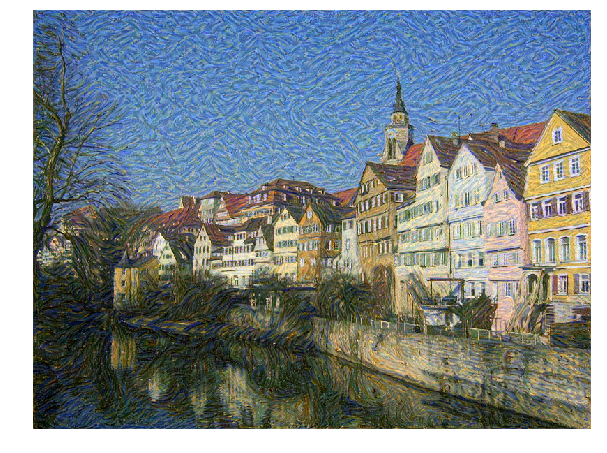

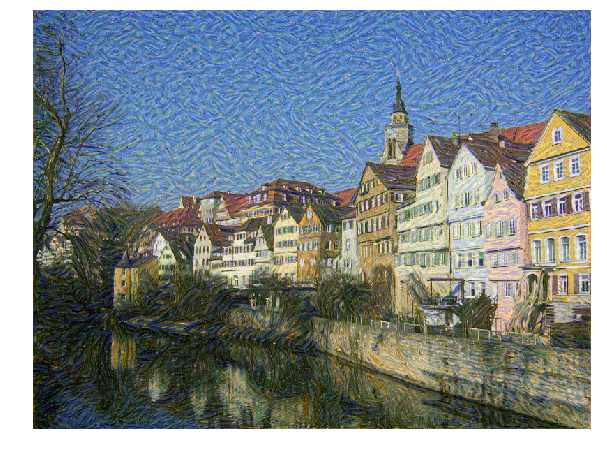

In [23]:
std_c=std_c.cuda()
mean_c=mean_c.cuda()
for i in range(100):
    feat_losses=[]
    in_feat=vgg_m(x[None],out_keys)
    feat_losses+=[base_loss(x,content)]
    feat_losses+=[base_loss(in_feat['r42'], content_target['r42'])*2]
    feat_losses+=[base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                                 for f_in, f_out, w in zip(in_feat.values(), style_target.values(), [3,5,15,2,2])]
    feat_losses.pop(-2)
    loss=sum(feat_losses)
    loss.backward()
    opt.step()
    opt.zero_grad()
    print(loss)
    if i%30==0:
            with torch.no_grad():
                r=torch.clamp_min(x*std_c[...,None,None]+mean_c[...,None,None],0)
                r=torch.clamp_max(r,1)
                show_image(r,figsize=(10,10))